<center>
    <img src="http://sct.inf.utfsm.cl/wp-content/uploads/2020/04/logo_di.png" style="width:60%">
    <h1> INF-495 - Modelado Computacional Aplicado </h1>
    <h2> Prof. Claudio Torres, Ph.D. </h2>
    <h2> Version: 1.02</h2>
</center>

## Textbook: Computational Mathematical Modeling, An Integrated Approach Across Scales by Daniela Calvetti and Erkki Somersalo.

# Chapter 2

In [11]:
import numpy as np
import scipy.sparse.linalg as sp
import sympy as sym
from scipy.linalg import toeplitz

import ipywidgets as widgets
from ipywidgets import IntSlider

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

plt.style.use('ggplot')

import matplotlib as mpl
mpl.rcParams['font.size'] = 14
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
sym.init_printing()

from scipy.integrate import solve_ivp
from ipywidgets import interact

## 2.1 Simple compartment models

### Example 1:

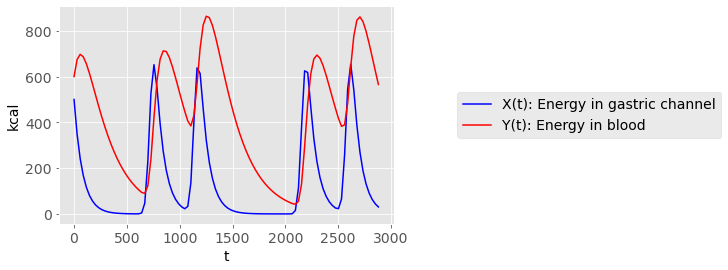

In [12]:
# Example 1, numerically.
def f_example_1(t,y,c,k1,k2):
    X = y[0]
    Y = y[1]
    
    Xp = c(t)-k1*X
    Yp = k1*X-k2*Y
    
    return np.array([Xp,Yp])

# Initial condition
y0 = np.array([500, 600])
a  = 1200
t1 = 12*60
t2 = 19*60
tau = 30
c  = lambda t: a*(np.exp(-((np.mod(t,24*60)-t1)**2)/(2*tau**2)) \
                +np.exp(-((np.mod(t,24*60)-t2)**2)/(2*tau**2))) \
                /(np.sqrt(2*np.pi*tau**2))

T_digest = 80
T_metabolic = 240
k1 = 1/T_digest
k2 = 1/T_metabolic

T = 2*24*60

# time where we want your solution
t = np.linspace(0, T, 100)
sol = solve_ivp(f_example_1, [0,T], y0, t_eval=t, args=(c,k1,k2))

plt.figure()
plt.plot(t, sol.y[0], 'b', label='X(t): Energy in gastric channel')
plt.plot(t, sol.y[1], 'r', label='Y(t): Energy in blood')
plt.legend(loc='right', bbox_to_anchor=(2, 0.5))
plt.xlabel('t')
plt.ylabel('kcal')
plt.grid(True)
plt.show()

In [13]:
print(t1,t2)

720 1140


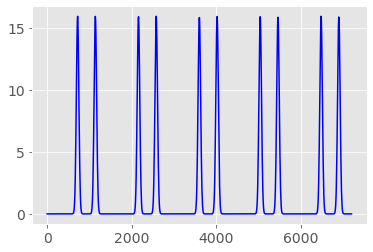

In [14]:
plt.figure()
T = 5*24*60
t = np.linspace(0, T, 1000)
plt.plot(t,c(t),'b')
plt.grid(True)
plt.plot()

## 2.1.1.- Simple population models

### Adding competition for resources: Logistic growth

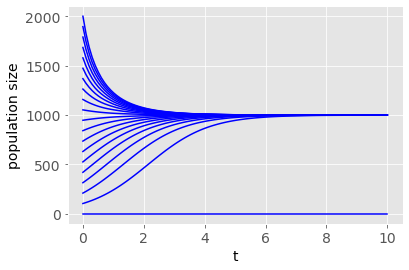

In [15]:
# Example 1, numerically.
def f_spm_logistic_growth(t,y,r,K):
    X = y
    Xp = r*(1-X/K)*X
    return Xp

# Initial condition
r = 1
K = 1000

T = 10

# time where we want your solution
t = np.linspace(0, T, 100)

plt.figure()
for y0 in np.linspace(0,2000,20):
    sol = solve_ivp(f_spm_logistic_growth, [0,T], (y0,), t_eval=t, args=(r,K))
    plt.plot(t, sol.y[0], 'b')
plt.xlabel('t')
plt.ylabel('population size')
plt.grid(True)
plt.show()

### Logistic growth with harvesting

250.0 100
887.2983346207417 112.7016653792583


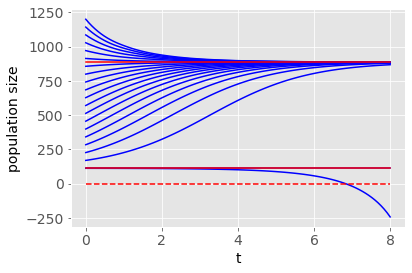

In [16]:
def f_logistic_growth_harvesting(t,y,r,K,h):
    X = y
    Xp = r*(1-X/K)*X-h
    return Xp

# Initial condition
r = 1
K = 1000
h = 100
print(K*r/4,h)

T = 8

Xplus = K/2*(1+np.sqrt(1-4*h/(K*r)))
Xminus = K/2*(1-np.sqrt(1-4*h/(K*r)))
print(Xplus,Xminus)

# time where we want your solution
t = np.linspace(0, T, 100)

plt.figure()
N=20
y0s = np.zeros(N+1)
y0s[0] = Xminus-0.5
y0s[1:] = np.linspace(Xminus,1200,N)
for y0 in y0s:
    sol = solve_ivp(f_logistic_growth_harvesting, [0,T], (y0,), t_eval=t, args=(r,K,h))
    plt.plot(t, sol.y[0], 'b')

plt.plot(t, sol.y[0]*0+Xplus, 'r')
plt.plot(t, sol.y[0]*0+Xminus, 'r')
plt.plot(t, sol.y[0]*0, 'r--')
plt.xlabel('t')
plt.ylabel('population size')
plt.grid(True)
plt.show()

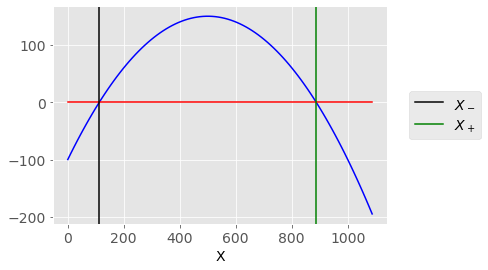

In [17]:
plt.figure()
f = lambda X: -(r/K)*X**2+r*X-h
Xs = np.linspace(0,Xplus+200,100)
plt.plot(Xs, f(Xs), 'b')
plt.plot(Xs, f(Xs)*0, 'r')
plt.axvline(x=Xminus,color='k',label='$X_-$')
plt.axvline(x=Xplus,color='g',label='$X_+$')
plt.xlabel('X')
plt.legend(loc='right', bbox_to_anchor=(1.3, 0.5))
plt.grid(True)
plt.show()

### Models with delay

### Example 2 --- oudated --- it needs a new DDE solver.

Differential equations with delay are not currently supported by Scipy, fortunately there are the following options:

- For Python: pydelay, http://pydelay.sourceforge.net
- For R: "PBSddesolve: Solver for delay differential equations", https://github.com/pbs-software/pbs-ddesolve 
- For Python using PBSddesolve: https://github.com/hensing/PyDDE
- (*) For Python: https://github.com/Zulko/ddeint

In [18]:
'''
# See: https://github.com/Zulko/ddeint
from ddeint import ddeint

r = 2         # Growth rate
K = 100       # Carrying capacity
tau = 1       # Lag of crowding
X_hist = 50   # Constant history
T = 30        # Time simulation

def values_before_zero(t):
    return X_hist

def f_delay1(Y, t):
    return r*(1-Y(t - tau)/K)*Y(t)

t = np.linspace(0, T, 1000)
sol = ddeint(f_delay1, values_before_zero, t)

fig, ax = plt.subplots(1, figsize=(4, 4))
ax.plot(t, sol)
plt.show()
'''

'\n# See: https://github.com/Zulko/ddeint\nfrom ddeint import ddeint\n\nr = 2         # Growth rate\nK = 100       # Carrying capacity\ntau = 1       # Lag of crowding\nX_hist = 50   # Constant history\nT = 30        # Time simulation\n\ndef values_before_zero(t):\n    return X_hist\n\ndef f_delay1(Y, t):\n    return r*(1-Y(t - tau)/K)*Y(t)\n\nt = np.linspace(0, T, 1000)\nsol = ddeint(f_delay1, values_before_zero, t)\n\nfig, ax = plt.subplots(1, figsize=(4, 4))\nax.plot(t, sol)\nplt.show()\n'

In [19]:
'''
r = 1.4       # Growth rate
K = 150       # Carrying capacity
tau1 = 1      # Lag of birth
tau2 = 5      # Lag of crowding
X_hist = 100  # Constant history
T = 300       # Time simulation
beta = 0.5    # Rate of death

def values_before_zero(t):
    return X_hist

def f_delay2(Y, t):
    return r*Y(t-tau1)-beta*Y(t)-(r/K)*Y(t - tau2)*Y(t)

t = np.linspace(0, T, 2000)
sol = ddeint(f_delay2, values_before_zero, t)

fig, ax = plt.subplots(1, figsize=(4, 4))
ax.plot(t, sol)
plt.show()
'''

'\nr = 1.4       # Growth rate\nK = 150       # Carrying capacity\ntau1 = 1      # Lag of birth\ntau2 = 5      # Lag of crowding\nX_hist = 100  # Constant history\nT = 300       # Time simulation\nbeta = 0.5    # Rate of death\n\ndef values_before_zero(t):\n    return X_hist\n\ndef f_delay2(Y, t):\n    return r*Y(t-tau1)-beta*Y(t)-(r/K)*Y(t - tau2)*Y(t)\n\nt = np.linspace(0, T, 2000)\nsol = ddeint(f_delay2, values_before_zero, t)\n\nfig, ax = plt.subplots(1, figsize=(4, 4))\nax.plot(t, sol)\nplt.show()\n'

## 2.2.- Interacting population models

## 2.2.1.- Predator-prey models

### Example 3

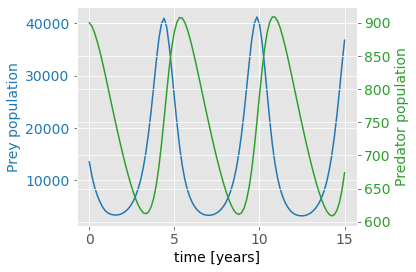

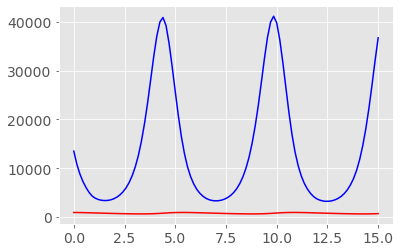

In [20]:
# Example 1, numerically.
def f_example_3(t,y,eta,gamma,eps):
    X = y[0]
    Y = y[1]
    
    Xp = eta*X*(1-Y/(eta/gamma))
    Yp = -eps*Y*(1-X/(eps/delta))
    
    return np.array([Xp,Yp])

# Initial condition

eta = 8-1/2
eps = 1/5
gamma = 1/100
delta = eps*gamma/(20*eta)

X_eq = eps/delta
Y_eq = eta/gamma

y0 = np.array([0.9*X_eq, 1.2*Y_eq])

T = 15

# time where we want your solution
t = np.linspace(0, T, 100)
sol = solve_ivp(f_example_3,[0,T], y0, t_eval=t, args=(eta,gamma,eps))

X_output = sol.y[0]
Y_output = sol.y[1]

fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('time [years]')
ax1.set_ylabel('Prey population', color=color)
ax1.plot(t, X_output, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:green'
ax2.set_ylabel('Predator population', color=color)  # we already handled the x-label with ax1
ax2.plot(t, Y_output, color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

plt.figure()
plt.plot(t,X_output,'b')
plt.plot(t,Y_output,'r')
plt.grid(True)
plt.show()

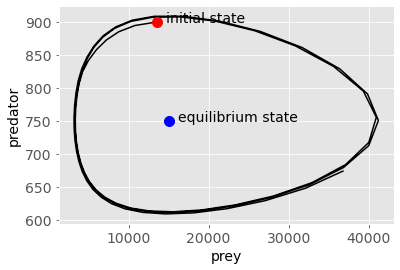

In [21]:
plt.figure()
plt.plot(X_output,Y_output,'k')
plt.xlabel('prey')
plt.ylabel('predator')
plt.plot(X_eq,Y_eq,'b.',markersize=20)
plt.plot(y0[0],y0[1],'r.',markersize=20)
plt.text(X_eq,Y_eq,'  equilibrium state')
plt.text(y0[0],y0[1],'  initial state')
plt.show()

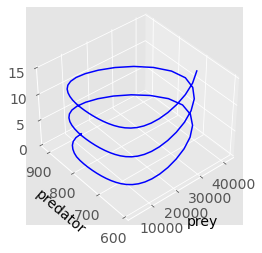

In [22]:
#fig = plt.figure()
#ax = fig.gca(projection='3d')
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot(X_output, Y_output, t,'b')
ax.view_init(elev=40,azim=230)
plt.xlabel('prey')
plt.ylabel('predator')
ax.set_zlabel('t')
plt.show()

## 2.2.2.- SIR models in epidemiology

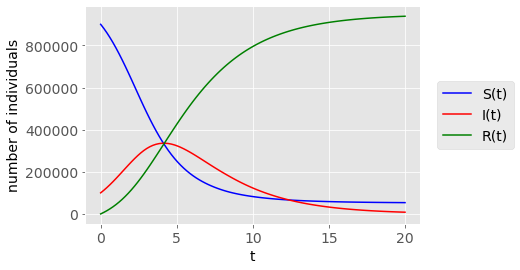

In [23]:
# Example 1, numerically.
def f_SIR(t,y,alpha,beta):
    S = y[0]
    I = y[1]
    R = y[2]
    
    Sp = -alpha*I*S
    Ip = alpha*I*S-beta*I
    Rp = beta*I
    
    return np.array([Sp,Ip,Rp])

# Initial condition
N = 1e6
alpha = 1e-6
beta = 1/3

S0 = 9e5
I0 = 1e5
y0 = np.array([S0, I0, N-S0-I0])

T = 20

# time where we want your solution
t = np.linspace(0, T, 100)
sol = solve_ivp(f_SIR, [0,T], y0, t_eval=t, args=(alpha,beta))

plt.figure()
plt.plot(t, sol.y[0], 'b', label='S(t)')
plt.plot(t, sol.y[1], 'r', label='I(t)')
plt.plot(t, sol.y[2], 'g', label='R(t)')
plt.legend(loc='right', bbox_to_anchor=(1.3, 0.5))
plt.xlabel('t')
plt.ylabel('number of individuals')
plt.grid(True)
plt.show()

## 2.2.3.- Endemic diseases

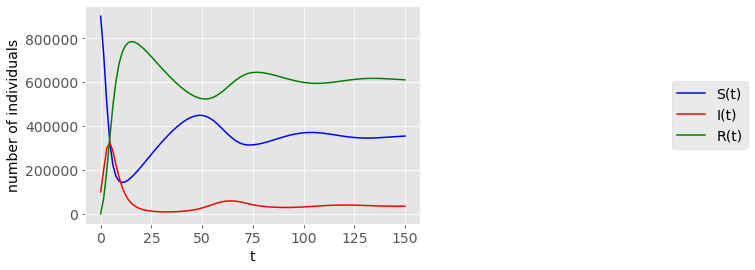

In [24]:
# Example 1, numerically.
def f_SIR_endemic(t,y,alpha,beta,sigma,N):
    S = y[0]
    I = y[1]
    R = y[2]
    
    Sp = -alpha*I*S+sigma*N-sigma*S
    Ip = alpha*I*S-beta*I-sigma*I
    Rp = beta*I-sigma*R
    
    return np.array([Sp,Ip,Rp])

# Initial condition
N = 1e6
alpha = 1e-6
beta = 1/3
sigma = 1/50

S0 = 9e5
I0 = 1e5
y0 = np.array([S0, I0, N-S0-I0])

T = 150

# time where we want your solution
t = np.linspace(0, T, 100)
sol = solve_ivp(f_SIR_endemic, [0,T], y0, t_eval=t, args=(alpha,beta,sigma,N))

plt.figure()
plt.plot(t, sol.y[0], 'b', label='S(t)')
plt.plot(t, sol.y[1], 'r', label='I(t)')
plt.plot(t, sol.y[2], 'g', label='R(t)')
plt.legend(loc='right', bbox_to_anchor=(2, 0.5))
plt.xlabel('t')
plt.ylabel('number of individuals')
plt.grid(True)
plt.show()

# 2.2 Subcompartment models

 Example 5

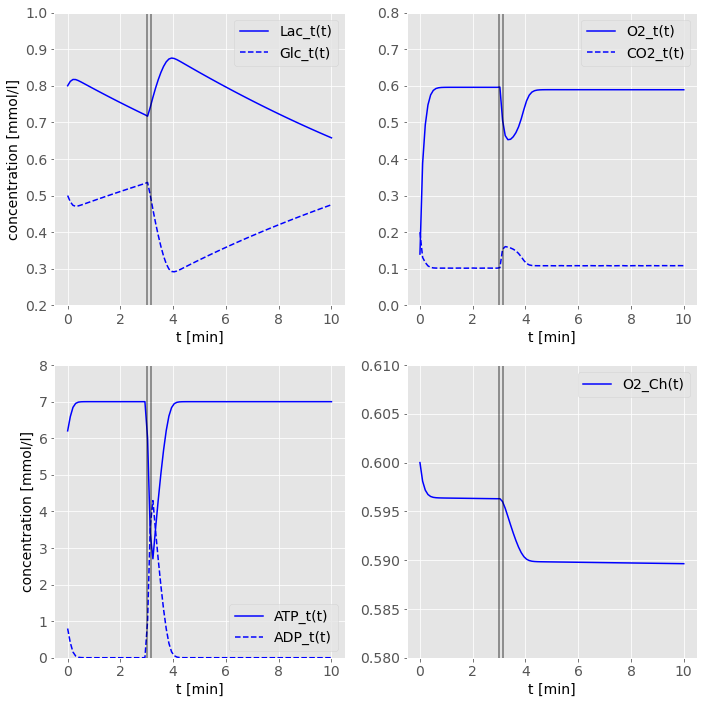

In [25]:
# Volumnes
Vol_ch = 50./1000
Vol_t  = 0.3/1000

# Initial conditions in chamber
Lac_ch_0 = 0.3
Glc_ch_0 = 1.6
O2_ch_0  = 0.6
CO2_ch_0 = 0.1
x0 = np.array([Lac_ch_0,Glc_ch_0,O2_ch_0,CO2_ch_0])

# Initial conditions in tissue
Lac_t_0  = 0.8
Glc_t_0  = 0.5
O2_t_0   = 0.14
CO2_t_0  = 0.2
ATP_t_0  = 6.2
ADP_t_0  = 0.8
y0 = np.array([Lac_t_0,Glc_t_0,O2_t_0,CO2_t_0,ATP_t_0,ADP_t_0])

# Maximum rates
T1 = 5e-5
T2 = 3e-5
V1 = 1e-4
V2 = 1e-4

# Affinities
M1 = 0.5
M2 = 0.5
K1 = 0.5
K2 = 0.22
mu1 = 0.1
mu2 = 0.1

#Fick's constants
lambda3 = 3e-3
lambda4 = 8e-3

# Constants defining the activity
t0  = 3. # min
tau = 10./60 # min

# Activity levels
a0      = 1e-5
delta_a = 1e-2

def f_example_5(t,z):
    x = z[:4]
    y = z[4:]
    
    Phi = np.zeros(4)
    Phi[0] = T1*((x[0]/(x[0]+M1))-(y[0]/(y[0]+M1)))
    Phi[1] = T2*((x[1]/(x[1]+M1))-(y[1]/(y[1]+M1)))
    Phi[2] = lambda3*(x[2]-y[2])
    Phi[3] = lambda4*(x[3]-y[3])
    
    p = y[5]/y[4]
    Psi1 = V1*(p/(p+mu1))*(y[1]/(y[1]+K1))
    rho1 = np.array([2.,-1,0,0,2,-2])*Psi1
    
    Psi2 = V2*(p/(p+mu2))*(y[1]*y[2]/(y[1]*y[2]+K2**2))
    rho2 = np.array([0.,-1,-6,6,32,-32])*Psi2
    
    a = a0+delta_a*(np.heaviside(t-(t0), 1)-np.heaviside(t-(t0+tau), 1))
    rho3 = np.array([0.,0,0,0,-1,1])*a
    
    dxdt = -Phi/Vol_ch
    
    dydt = np.zeros(6)
    dydt[:4] = Phi
    dydt += rho1+rho2+rho3
    dydt /=Vol_t
    return np.concatenate((dxdt,dydt), axis=0)

# Initial condition
z0 = np.concatenate((x0,y0), axis=0)

T = 10
# time where we want your solution
t = np.linspace(0, T, 100)

sol = solve_ivp(f_example_5, [0,T], z0, t_eval=t)

plt.figure(figsize=(10,10))

plt.subplot(221)
plt.plot(t, sol.y[4], 'b-', label='Lac_t(t)')
plt.plot(t, sol.y[5], 'b--', label='Glc_t(t)')
plt.legend(loc='best')
plt.axvline(x=t0,color='k',alpha=0.5)
plt.axvline(x=t0+tau,color='k',alpha=0.5)
plt.xlabel('t [min]')
plt.ylabel('concentration [mmol/l]')
plt.ylim([0.2,1])
plt.grid(True)

plt.subplot(222)
plt.plot(t, sol.y[6], 'b-', label='O2_t(t)')
plt.plot(t, sol.y[7], 'b--', label='CO2_t(t)')
plt.legend(loc='best')
plt.axvline(x=t0,color='k',alpha=0.5)
plt.axvline(x=t0+tau,color='k',alpha=0.5)
plt.xlabel('t [min]')
#plt.ylabel('concentration [mmol/l]')
plt.ylim([0,0.8])
plt.grid(True)

plt.subplot(223)
plt.plot(t, sol.y[8], 'b-', label='ATP_t(t)')
plt.plot(t, sol.y[9], 'b--', label='ADP_t(t)')
plt.legend(loc='best')
plt.axvline(x=t0,color='k',alpha=0.5)
plt.axvline(x=t0+tau,color='k',alpha=0.5)
plt.xlabel('t [min]')
plt.ylabel('concentration [mmol/l]')
plt.ylim([0,8])
plt.grid(True)

plt.subplot(224)
plt.plot(t, sol.y[2], 'b-', label='O2_Ch(t)')
plt.legend(loc='best')
plt.axvline(x=t0,color='k',alpha=0.5)
plt.axvline(x=t0+tau,color='k',alpha=0.5)
plt.xlabel('t [min]')
#plt.ylabel('concentration [mmol/l]')
plt.ylim([0.58,0.61])
plt.grid(True)

plt.tight_layout()
plt.show()